In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths
train_path = "D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\endoscopic images"  # Adjust the path accordingly

# Data Preprocessing with ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training and Validation Generators
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)




Found 6770 images belonging to 2 classes.
Found 1692 images belonging to 2 classes.


In [2]:
# Load InceptionV3 Model (Pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing initial layers
for layer in base_model.layers:
    layer.trainable = False

# Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Dropout to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Additional dropout
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [3]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

Epoch 1/10
211/211 [==============================] - 400s 2s/step - loss: 0.4082 - accuracy: 0.8102 - val_loss: 0.1816 - val_accuracy: 0.9297
Epoch 2/10
211/211 [==============================] - 386s 2s/step - loss: 0.2152 - accuracy: 0.9139 - val_loss: 0.1436 - val_accuracy: 0.9453
Epoch 3/10
211/211 [==============================] - 366s 2s/step - loss: 0.1684 - accuracy: 0.9317 - val_loss: 0.1145 - val_accuracy: 0.9573
Epoch 4/10
211/211 [==============================] - 351s 2s/step - loss: 0.1577 - accuracy: 0.9377 - val_loss: 0.0938 - val_accuracy: 0.9609
Epoch 5/10
211/211 [==============================] - 371s 2s/step - loss: 0.1441 - accuracy: 0.9451 - val_loss: 0.1145 - val_accuracy: 0.9585
Epoch 6/10
211/211 [==============================] - 341s 2s/step - loss: 0.1283 - accuracy: 0.9504 - val_loss: 0.0914 - val_accuracy: 0.9657
Epoch 7/10
211/211 [==============================] - 325s 2s/step - loss: 0.1351 - accuracy: 0.9488 - val_loss: 0.1046 - val_accuracy: 0.9561

In [4]:
model.save("D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\models\\InceptionV3_base.h5")

c:\Users\Sri Aravindh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
print(train_generator.class_indices)

{'augmented_esophagus': 0, 'augumented_non_esophagus': 1}


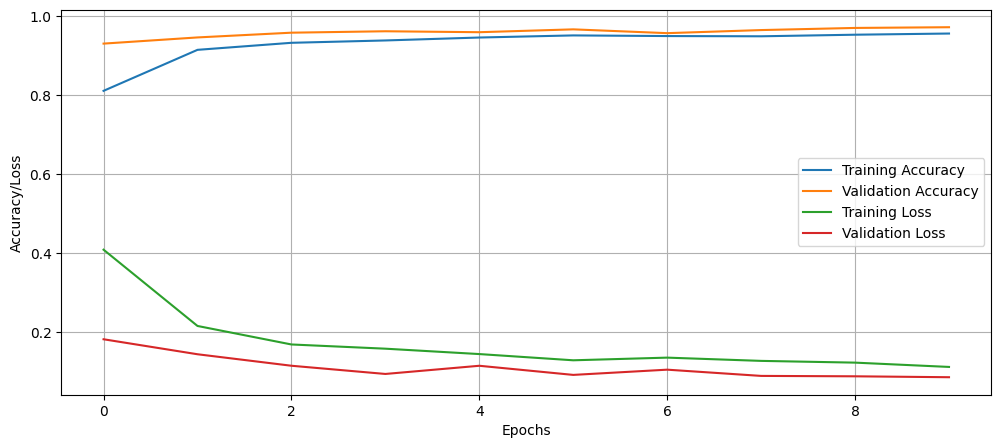

In [6]:
# Plotting Training and Validation Curves
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid()
plt.show()


In [7]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


53/53 [==============================] - 67s 1s/step - loss: 0.0842 - accuracy: 0.9752
Validation Loss: 0.0842
Validation Accuracy: 97.52%


In [ ]:
'''import numpy as np
from tensorflow.keras.preprocessing import image

def predict_escc(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    
    prediction = model.predict(img_array)
    
    if prediction[0][0] > 0.5:
        print(prediction[0][0])
        print("Prediction: (ESCC)")
    else:
        print("Prediction: (Non-ESCC)")

# Example
predict_escc("D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\endoscopic images\\ESCC(kettevan)\\0b93c4df-2bb2-4d56-af1c-eeb22bf856d5.jpg")'''


1/1 [==============================] - 0s 120ms/step
0.76964813
Prediction: (ESCC)


In [2]:
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = 'D:\\data conquest\\ESOPHEGEAL CANCER DETECTION\\models\\InceptionV3_base.h5'

# Load the model
model = load_model(model_path)

# Verify the model structure
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
# from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
#                              confusion_matrix, roc_auc_score, log_loss, cohen_kappa_score,
#                              matthews_corrcoef, classification_report, roc_curve, auc)
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# def evaluate_model(model, test_generator, threshold=0.5):
#     """
#     Evaluate the model on various metrics like accuracy, precision, recall, F1-score, 
#     confusion matrix, ROC-AUC, and more.
    
#     Args:
#         model: Trained model to be evaluated.
        
#         test_generator: The test data generator.
#         threshold: Probability threshold for binary classification. Default is 0.5.
#     """
#     # Ensure the test generator is reset
#     test_generator.reset()

#     # Predictions and true labels
#     predictions = model.predict(test_generator)
#     predicted_classes = (predictions > threshold).astype(int)
#     true_classes = test_generator.classes
#     class_labels = list(test_generator.class_indices.keys())  # Fetch class labels

#     # Classification Report
#     print("🔹 Classification Report:")
#     print(classification_report(true_classes, predicted_classes, target_names=class_labels))

#     # Accuracy, Precision, Recall, F1-Score
#     accuracy = accuracy_score(true_classes, predicted_classes)
#     precision = precision_score(true_classes, predicted_classes)
#     recall = recall_score(true_classes, predicted_classes)
#     f1 = f1_score(true_classes, predicted_classes)
    
#     print(f"\n🔹 Accuracy: {accuracy:.2f}")
#     print(f"🔹 Precision: {precision:.2f}")
#     print(f"🔹 Recall (Sensitivity): {recall:.2f}")
#     print(f"🔹 F1-Score: {f1:.2f}")

#     # Confusion Matrix
#     cm = confusion_matrix(true_classes, predicted_classes)
#     tn, fp, fn, tp = cm.ravel()
#     specificity = tn / (tn + fp)

#     print(f"🔹 Specificity: {specificity:.2f}")

#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # ROC-AUC
#     if len(class_labels) == 2:  # Only for binary classification
#         fpr, tpr, _ = roc_curve(true_classes, predictions)
#         roc_auc = auc(fpr, tpr)
#         print(f"🔹 ROC-AUC: {roc_auc:.2f}")

#         plt.figure(figsize=(6, 5))
#         plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#         plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver Operating Characteristic (ROC) Curve')
#         plt.legend(loc="lower right")
#         plt.show()

#     # Log Loss
#     logloss = log_loss(true_classes, predictions)
#     print(f"🔹 Log Loss: {logloss:.2f}")

#     # Cohen's Kappa
#     kappa = cohen_kappa_score(true_classes, predicted_classes)
#     print(f"🔹 Cohen's Kappa: {kappa:.2f}")

#     # Matthews Correlation Coefficient (MCC)
#     mcc = matthews_corrcoef(true_classes, predicted_classes)
#     print(f"🔹 Matthews Correlation Coefficient (MCC): {mcc:.2f}")



1/1 [==============================] - 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       846
         1.0       0.96      0.97      0.97       846

    accuracy                           0.97      1692
   macro avg       0.97      0.97      0.97      1692
weighted avg       0.97      0.97      0.97      1692



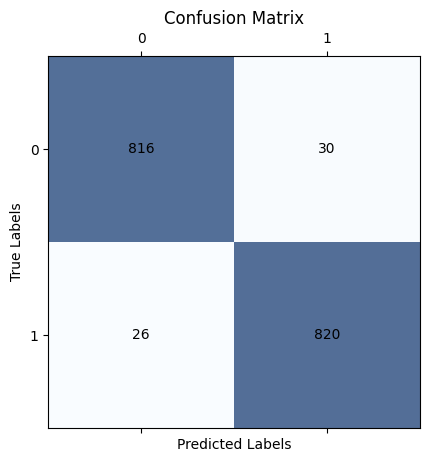

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the total number of samples in the validation set
total_samples = len(val_generator.filenames)

# Initialize lists to collect all true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Loop through all batches in the validation generator
for i in range(len(val_generator)):
    x_batch, y_true_batch = val_generator[i]  # Get the i-th batch
    all_true_labels.extend(y_true_batch)
    y_pred_prob_batch = model.predict(x_batch)
    all_pred_probs.extend(y_pred_prob_batch)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

# Set the optimal threshold and get predicted labels
optimal_threshold = 0.5
all_pred_labels = (all_pred_probs >= optimal_threshold).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.matshow(cm, cmap='Blues', alpha=0.7)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()


